## Threshold for condition:
We want to decide wether a problem is unique or non unique depending on this threshold.

 We choose the threshoold $T$ as 
 $$T = \frac{\tilde{\sigma}_1}{\sqrt{E}} $$
where $E = m(C_m \frac{\epsilon}{h} + h^{order} M C_a)^2 + \|u-\tilde{u}\|_2^2$ and $\epsilon = \|u-u_{noise}\|_{\infty} + 10^{-16}$ and $h=dx$. If a value is bigger than T the function u should be nonunique.

In [1]:
import numpy as np
from numpy.linalg import matrix_rank, svd
from test_data import experiment_data,add_noise,create_data_2d
import pysindy as ps
import matplotlib.pyplot as plt

In [25]:
"""
n: number of data points used for approximation/ order
k: number of lagrange coefficient
l: input to lagrange coefficient: x = x_l = x+ hl
"""
#Computes the coefficients of the derivitve of the kth Lagrangian Coefficients
#These are also the coefficients used for finite differences
def lagrange_coefficient_derivative(n,k,l):
    erg=0.0        
    for j in range(n+1):
        if j!=k:
            tmp =1.0
            for i in range(n+1):
                  if i!=k and i!=j:
                    tmp *=(l-i)/(k-i)
                    #print(f"l-k = {l}-{i}")
            tmp*=1.0/(k-j)
            erg+=tmp
    return erg
    
#Sums up the above coefficients
#needed for measurment error
def sum_lagrange_coefficient_derivative(n,l):
    erg=0.0
    for k in range(n+1):
        #print(f"L({n},{k},{l}) = {lagrange_coefficient_derivative(n,k,l)}")
        erg+= np.abs(lagrange_coefficient_derivative(n,k,l))
    return erg

# Approximation error central differences: reduces with higher order n
def appr_error_central_diff(n):
    assert(n%2==0) #Check if n is even
    bound = (np.math.factorial(int(n/2))**2)/np.math.factorial(n+1)
    return bound
    
# Approximation error backward differences: reduces with higher order n
def appr_error_backward_diff(n):
    return 1/(n+1)

# Measurement error central differences
def meas_error_central_diff(n):
    assert(n%2==0) #Check if n is even
    erg=sum_lagrange_coefficient_derivative(n,n/2)
    return erg
    
# Measurement error backward differences
def meas_error_backward_diff(n):
    erg=sum_lagrange_coefficient_derivative(n,0)
    return erg



"""
eps: measurement error+round of error (Does it make sense to add machine precision?)
h: dx for equispaced data
M: bound on (order+1)th derivative
"""
def error_bound(eps,h,M,order=2):
    eps+=np.finfo(float).eps # add machine precisoin
    if order%2==0: #even order
        C_app=appr_error_central_diff(order)
        C_meas=meas_error_central_diff(order)
    else: # odd order
        C_app=appr_error_backward_diff(order)
        C_meas=meas_error_backward_diff(order)
    #print(f" C_meas*eps/h + (h**order)*M*C_app = {C_meas:2.3e}*{eps:2.3e}/{h:2.3e} + {h**order:2.3e}*{M:2.3e}*{C_app:2.3e}")    
    return C_meas*eps/h + (h**order)*M*C_app
            
def infinity_norm(x):
    return np.max(np.abs(x))

"""
eps_two: ||u-u_noise||_2 two norm
eps_infty: ||u-u_noise||_infty infinity norm
h: dx for equispaced data
number_datapoints: number of total datapoints where u is evaluated
M: bound on nth derivative depending on the order
"""
def error_bound_g(eps_two,eps_infty,h,number_datapoints,M,order):
    E = eps_two**2 + number_datapoints*error_bound(eps_infty,h,M,order)**2
    return E


In [26]:
def calc_threshold(eps,h,number_datapoints,order=2):
    eps+=np.finfo(float).eps # add machine precisoin
    if order%2==0: #even order
        C_meas=meas_error_central_diff(order)
    else: # odd order
        C_meas=meas_error_backward_diff(order)
    return 1/(eps/h+h**order)

def calc_threshold2(eps_two,eps_infty,h,number_datapoints,M,order=2): 
    E = error_bound_g(eps_two,eps_infty,h,number_datapoints,M,order)
    return 1/np.sqrt(E)

In [27]:
n_samples=50
T,X,t,x = create_data_2d(T_start=-5, T_end=1, L_x_start=0,L_x_end=1, N_t=n_samples, N_x=n_samples)
a=np.random.randn()

u = np.exp(X-a*T)
ux = u
uxx = u
uxxx = u
ut = -a*u

dx=x[1]-x[0]

In [28]:
u_flat, ux_flat = u.flatten(), ux.flatten()
true_g = np.concatenate([u_flat.reshape(len(u_flat),1), ux_flat.reshape(len(ux_flat),1)], axis=1)
sv = svd(true_g, compute_uv=False)
sv_max,sv_min=sv[0],sv[-1]
print(f"M: {np.max(u)}")
print(f"Singular values of g: {sv_max,sv_min}")
print(f"sv_max/sv_min: {sv_max/sv_min:3.3e}")

M: 419.78018402307447
Singular values of g: (5920.42559236558, 2.1248696214126395e-13)
sv_max/sv_min: 2.786e+16


In [29]:
u_flat, ux_flat = u.flatten(), ux.flatten()
true_g = np.concatenate([u_flat.reshape(len(u_flat),1), ux_flat.reshape(len(ux_flat),1)], axis=1)
sv = svd(true_g, compute_uv=False)
sv_max,sv_min=sv[0],sv[-1]
print(f"M: {np.max(u)}")
print(f"Singular values of g: {sv_max,sv_min}")
print(f"sv_max/sv_min: {sv_max/sv_min:3.3e}")

M: 419.78018402307447
Singular values of g: (5920.42559236558, 2.1248696214126395e-13)
sv_max/sv_min: 2.786e+16


True ratio: 2.786e+16
Noise level 	 order 	 	 ratio 	 	 threshold 	 	 threshold2
0
0.0
	  	 2 	 	 4.352e+04 	 2.401e+03 	 6.864e-01
	  	 3 	 	 4.214e+06 	 1.176e+05 	 2.242e+01
	  	 4 	 	 2.803e+08 	 5.765e+06 	 8.240e+03
	  	 5 	 	 1.416e+10 	 2.825e+08 	 8.075e+04
	  	 6 	 	 8.514e+11 	 1.384e+10 	 9.232e+07
	  	 7 	 	 2.898e+13 	 6.733e+11 	 2.568e+08
	  	 8 	 	 2.401e+13 	 2.441e+13 	 4.682e+11
	  	 9 	 	 1.702e+13 	 8.700e+13 	 1.339e+10


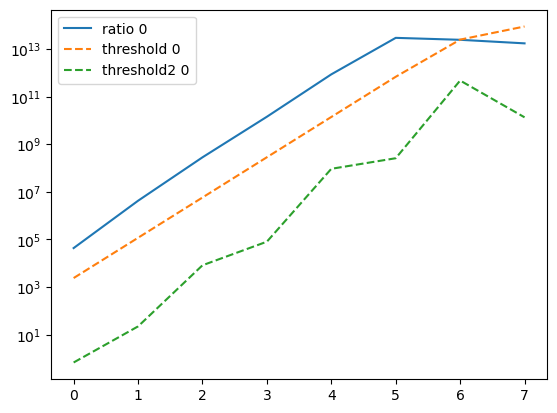

Noise level 	 order 	 	 ratio 	 	 threshold 	 	 threshold2
1e-10
4.2504895686629144e-07
	  	 2 	 	 4.352e+04 	 2.391e+03 	 6.863e-01
	  	 3 	 	 4.217e+06 	 9.743e+04 	 2.213e+01
	  	 4 	 	 2.069e+08 	 5.161e+05 	 3.942e+03
	  	 5 	 	 1.974e+08 	 5.657e+05 	 6.588e+02
	  	 6 	 	 1.418e+08 	 5.668e+05 	 6.183e+03
	  	 7 	 	 9.065e+07 	 5.668e+05 	 2.463e+02
	  	 8 	 	 5.569e+07 	 5.668e+05 	 5.441e+03
	  	 9 	 	 3.290e+07 	 5.668e+05 	 8.403e+01


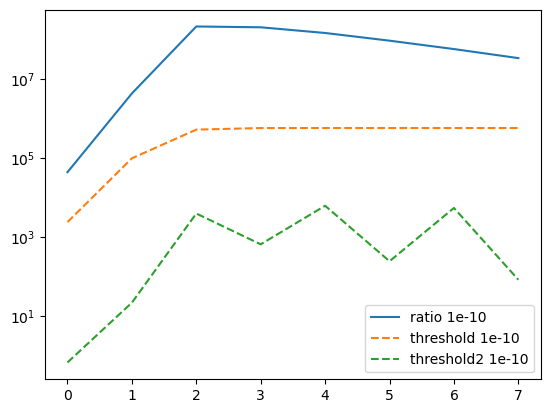

Noise level 	 order 	 	 ratio 	 	 threshold 	 	 threshold2
1e-09
4.20790650007842e-06
	  	 2 	 	 4.352e+04 	 2.318e+03 	 6.860e-01
	  	 3 	 	 4.168e+06 	 4.255e+04 	 2.016e+01
	  	 4 	 	 2.697e+07 	 6.589e+04 	 8.022e+02
	  	 5 	 	 1.982e+07 	 6.663e+04 	 7.803e+01
	  	 6 	 	 1.498e+07 	 6.665e+04 	 7.271e+02
	  	 7 	 	 9.906e+06 	 6.665e+04 	 2.897e+01
	  	 8 	 	 6.229e+06 	 6.665e+04 	 6.398e+02
	  	 9 	 	 3.756e+06 	 6.665e+04 	 9.881e+00


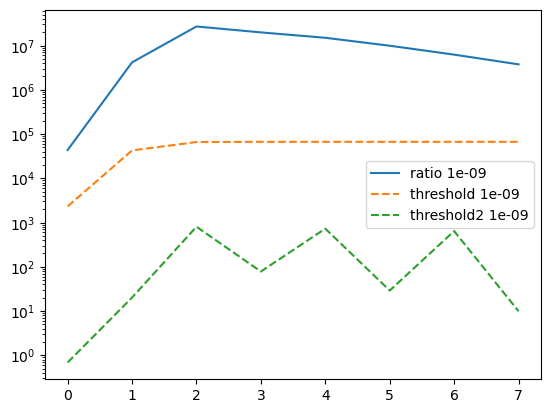

Noise level 	 order 	 	 ratio 	 	 threshold 	 	 threshold2
1e-08
4.211292392622497e-05
	  	 2 	 	 4.352e+04 	 1.719e+03 	 6.825e-01
	  	 3 	 	 2.405e+06 	 5.761e+03 	 1.004e+01
	  	 4 	 	 2.696e+06 	 6.051e+03 	 7.998e+01
	  	 5 	 	 1.958e+06 	 6.057e+03 	 7.098e+00
	  	 6 	 	 1.453e+06 	 6.057e+03 	 6.608e+01
	  	 7 	 	 9.520e+05 	 6.057e+03 	 2.633e+00
	  	 8 	 	 5.933e+05 	 6.057e+03 	 5.815e+01
	  	 9 	 	 3.543e+05 	 6.057e+03 	 8.980e-01


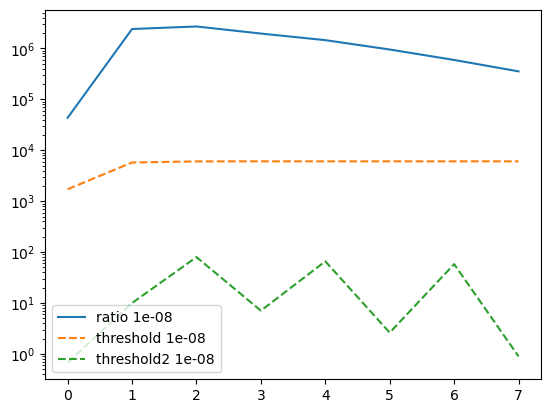

Noise level 	 order 	 	 ratio 	 	 threshold 	 	 threshold2
1e-07
0.0004130283599295401
	  	 2 	 	 4.362e+04 	 5.229e+02 	 6.528e-01
	  	 3 	 	 3.041e+05 	 6.647e+02 	 1.841e+00
	  	 4 	 	 2.928e+05 	 6.684e+02 	 8.903e+00
	  	 5 	 	 2.135e+05 	 6.685e+02 	 7.833e-01
	  	 6 	 	 1.578e+05 	 6.685e+02 	 7.292e+00
	  	 7 	 	 1.013e+05 	 6.685e+02 	 2.905e-01
	  	 8 	 	 6.196e+04 	 6.685e+02 	 6.417e+00
	  	 9 	 	 3.649e+04 	 6.685e+02 	 9.910e-02


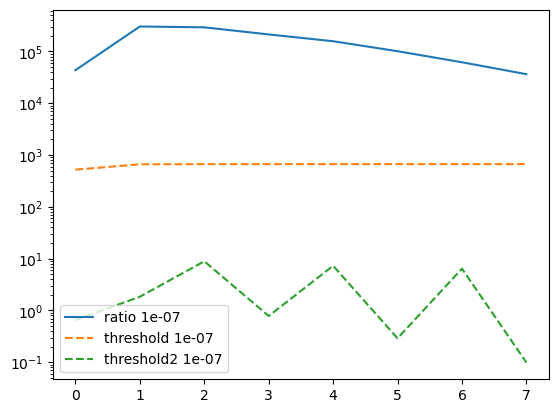

Noise level 	 order 	 	 ratio 	 	 threshold 	 	 threshold2
1e-06
0.0041426226203368265
	  	 2 	 	 3.025e+04 	 6.353e+01 	 4.498e-01
	  	 3 	 	 2.967e+04 	 6.522e+01 	 1.941e-01
	  	 4 	 	 2.804e+04 	 6.526e+01 	 8.700e-01
	  	 5 	 	 2.006e+04 	 6.526e+01 	 7.648e-02
	  	 6 	 	 1.474e+04 	 6.526e+01 	 7.119e-01
	  	 7 	 	 9.647e+03 	 6.526e+01 	 2.836e-02
	  	 8 	 	 6.011e+03 	 6.526e+01 	 6.265e-01
	  	 9 	 	 3.549e+03 	 6.526e+01 	 9.675e-03


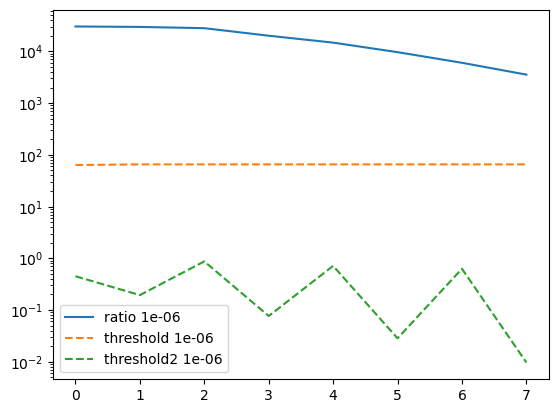

Noise level 	 order 	 	 ratio 	 	 threshold 	 	 threshold2
1e-05
0.042953619939746494
	  	 2 	 	 4.525e+03 	 5.866e+00 	 1.004e-01
	  	 3 	 	 2.832e+03 	 5.880e+00 	 1.763e-02
	  	 4 	 	 2.655e+03 	 5.880e+00 	 7.840e-02
	  	 5 	 	 1.959e+03 	 5.880e+00 	 6.891e-03
	  	 6 	 	 1.490e+03 	 5.880e+00 	 6.415e-02
	  	 7 	 	 9.951e+02 	 5.880e+00 	 2.556e-03
	  	 8 	 	 6.224e+02 	 5.880e+00 	 5.645e-02
	  	 9 	 	 3.665e+02 	 5.880e+00 	 8.717e-04


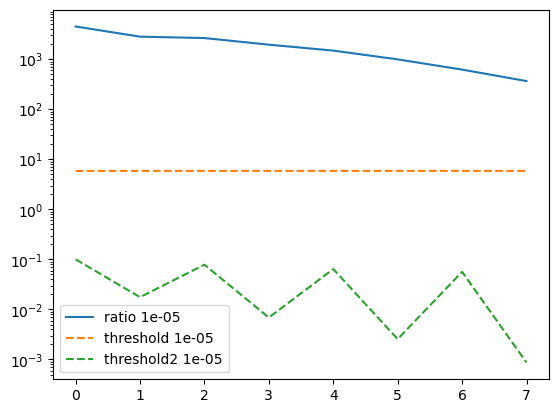

Noise level 	 order 	 	 ratio 	 	 threshold 	 	 threshold2
0.0001
0.42987482998520676
	  	 2 	 	 4.596e+02 	 5.429e-01 	 1.069e-02
	  	 3 	 	 2.892e+02 	 5.430e-01 	 1.629e-03
	  	 4 	 	 2.762e+02 	 5.430e-01 	 7.240e-03
	  	 5 	 	 2.002e+02 	 5.430e-01 	 6.363e-04
	  	 6 	 	 1.499e+02 	 5.430e-01 	 5.923e-03
	  	 7 	 	 1.000e+02 	 5.430e-01 	 2.360e-04
	  	 8 	 	 6.362e+01 	 5.430e-01 	 5.213e-03
	  	 9 	 	 3.806e+01 	 5.430e-01 	 8.050e-05


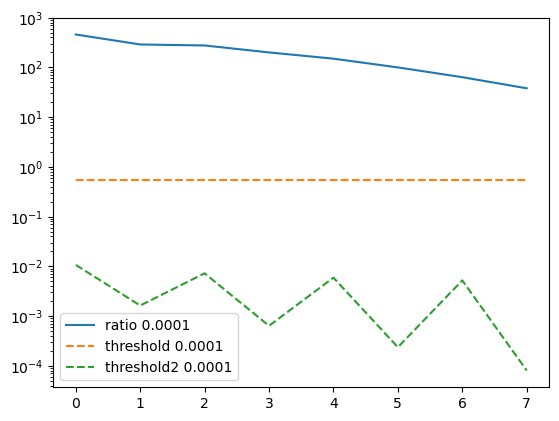

Noise level 	 order 	 	 ratio 	 	 threshold 	 	 threshold2
0.001
4.218383853568717
	  	 2 	 	 4.832e+01 	 6.145e-02 	 1.227e-03
	  	 3 	 	 2.948e+01 	 6.145e-02 	 1.843e-04
	  	 4 	 	 2.820e+01 	 6.145e-02 	 8.193e-04
	  	 5 	 	 2.054e+01 	 6.145e-02 	 7.201e-05
	  	 6 	 	 1.545e+01 	 6.145e-02 	 6.703e-04
	  	 7 	 	 1.003e+01 	 6.145e-02 	 2.671e-05
	  	 8 	 	 6.117e+00 	 6.145e-02 	 5.899e-04
	  	 9 	 	 3.683e+00 	 6.145e-02 	 9.110e-06


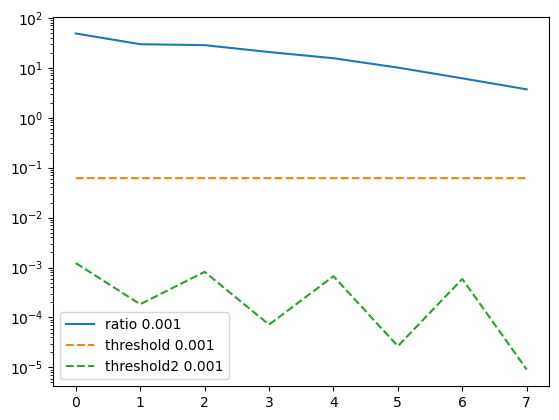

Noise level 	 order 	 	 ratio 	 	 threshold 	 	 threshold2
0.01
40.8084458509702
	  	 2 	 	 5.316e+00 	 5.874e-03 	 1.175e-04
	  	 3 	 	 3.455e+00 	 5.874e-03 	 1.762e-05
	  	 4 	 	 3.297e+00 	 5.874e-03 	 7.832e-05
	  	 5 	 	 2.602e+00 	 5.874e-03 	 6.884e-06
	  	 6 	 	 2.374e+00 	 5.874e-03 	 6.408e-05
	  	 7 	 	 2.691e+00 	 5.874e-03 	 2.553e-06
	  	 8 	 	 3.746e+00 	 5.874e-03 	 5.639e-05
	  	 9 	 	 5.829e+00 	 5.874e-03 	 8.709e-07


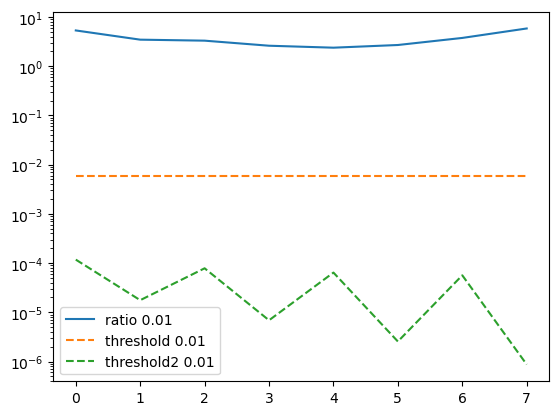

In [32]:
M=infinity_norm(uxxx)
number_noise=10 #<=10
noise_levels = [0]+[10**(-10+i) for i in range(0,number_noise-1)]
orders=range(2,10,1)
print(f"True ratio: {sv_max/sv_min:3.3e}")
unorm2=np.sqrt(np.mean(np.square(u)))

for target_noise in noise_levels:
    print("Noise level \t order \t \t ratio \t \t threshold \t \t threshold2")
    print(f"{target_noise}")
    threshold_list = []
    threshold2_list = []
    ratio_list=[]
    
    var = target_noise * unorm2
    noise = np.random.normal(0, var, size=u.shape)
    print(np.linalg.norm(noise))
    u_noise = u + noise
    eps_infty = infinity_norm(u-u_noise)
    eps_two = np.linalg.norm(u-u_noise)
    
    for order in orders:          
        ux_noise = ps.FiniteDifference(order=order,d=1, axis=0, drop_endpoints=False)._differentiate(u_noise, dx)
        u_flat_noise, u_x_flat_noise = u_noise.flatten(), ux_noise.flatten()
        g_noise = np.concatenate([u_flat_noise.reshape(len(u_flat_noise),1), u_x_flat_noise.reshape(len(u_flat_noise),1)], axis=1)
        sv = svd(g_noise, compute_uv=False)
        
        ratio=sv[0]/sv[-1]
        threshold = calc_threshold(eps_infty,dx,true_g.shape[0],order)
        threshold_list.append(threshold)
        threshold2 = calc_threshold2( eps_two,eps_infty,dx,true_g.shape[0],M,order)
        threshold2_list.append(threshold2)
        ratio_list.append(ratio)
        
        print(f"\t  \t {order} \t \t {ratio:3.3e} \t {threshold:3.3e} \t {threshold2:3.3e}")
    
    plt.plot(ratio_list,label=f'ratio {target_noise}')
    plt.plot(threshold_list,'--',label=f'threshold {target_noise}')
    plt.plot(threshold2_list,'--',label=f'threshold2 {target_noise}')
    plt.yscale('log')
    plt.legend()
    plt.show()

##### We try if the threshold also holds for non unqiue values

In [8]:
def calc_threshold_uniq(eps,h,number_datapoints,order=2):
    eps+=np.finfo(float).eps # add machine precisoin
    if order%2==0: #even order
        C_meas=meas_error_central_diff(order)
    else: # odd order
        C_meas=meas_error_backward_diff(order)
    return (eps/h+h**order)*1e8

In [9]:
n_samples=100
T,X,t,x = create_data_2d(T_start=0, T_end=5, L_x_start=-2,L_x_end=1, N_t=n_samples, N_x=n_samples)
a=np.random.randn()*6
C=2

u = np.cos(X-a*T)*C
ux = -np.sin(X-a*T)*C
uxx = -np.cos(X-a*T)*C
uxxx = np.sin(X-a*T)*C
ut = a*np.sin(X-a*T)*C

dx=x[1]-x[0]

In [10]:
u_flat, ux_flat = u.flatten(), ux.flatten()
true_g = np.concatenate([u_flat.reshape(len(u_flat),1), ux_flat.reshape(len(ux_flat),1)], axis=1)
sv = svd(true_g, compute_uv=False)
sv_max,sv_min=sv[0],sv[-1]
print(f"M: {np.max(u)}")
print(f"Singular values of g: {sv_max,sv_min}")
print(f"sv_max/sv_min: {sv_max/sv_min:3.3e}")

M: 2.0
Singular values of g: (141.6122180133666, 141.23023652651273)
sv_max/sv_min: 1.003e+00


True ratio: 1.003e+00
Noise level 	 order 	 	 ratio 	 	 threshold
0
0.0
	  	 2 	 	 1.003e+00 	 1.089e+03
	  	 3 	 	 1.003e+00 	 3.594e+04
	  	 4 	 	 1.003e+00 	 1.186e+06
	  	 5 	 	 1.003e+00 	 3.914e+07
	  	 6 	 	 1.003e+00 	 1.291e+09
	  	 7 	 	 1.003e+00 	 4.261e+10
	  	 8 	 	 1.003e+00 	 1.392e+12
	  	 9 	 	 1.003e+00 	 3.463e+13


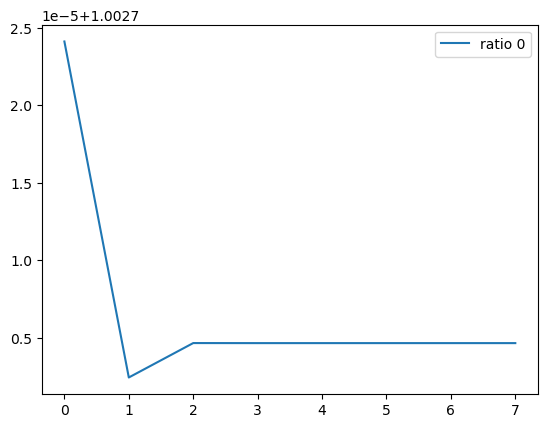

Noise level 	 order 	 	 ratio 	 	 threshold
1e-10
1.4233571938365315e-08
	  	 2 	 	 1.003e+00 	 1.089e+03
	  	 3 	 	 1.003e+00 	 3.591e+04
	  	 4 	 	 1.003e+00 	 1.161e+06
	  	 5 	 	 1.003e+00 	 2.294e+07
	  	 6 	 	 1.003e+00 	 5.317e+07
	  	 7 	 	 1.003e+00 	 5.538e+07
	  	 8 	 	 1.003e+00 	 5.545e+07
	  	 9 	 	 1.003e+00 	 5.545e+07


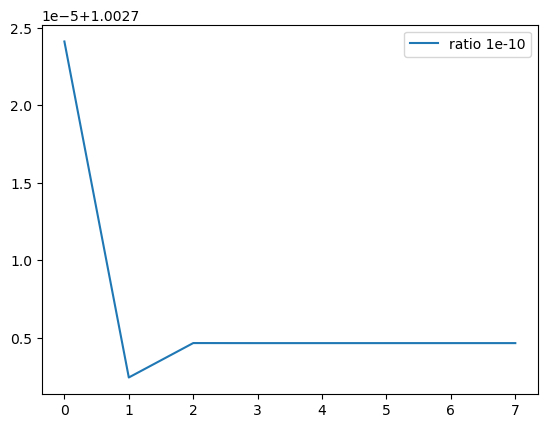

Noise level 	 order 	 	 ratio 	 	 threshold
1e-09
1.4149275998601375e-07
	  	 2 	 	 1.003e+00 	 1.089e+03
	  	 3 	 	 1.003e+00 	 3.567e+04
	  	 4 	 	 1.003e+00 	 9.544e+05
	  	 5 	 	 1.003e+00 	 4.347e+06
	  	 6 	 	 1.003e+00 	 4.871e+06
	  	 7 	 	 1.003e+00 	 4.889e+06
	  	 8 	 	 1.003e+00 	 4.890e+06
	  	 9 	 	 1.003e+00 	 4.890e+06


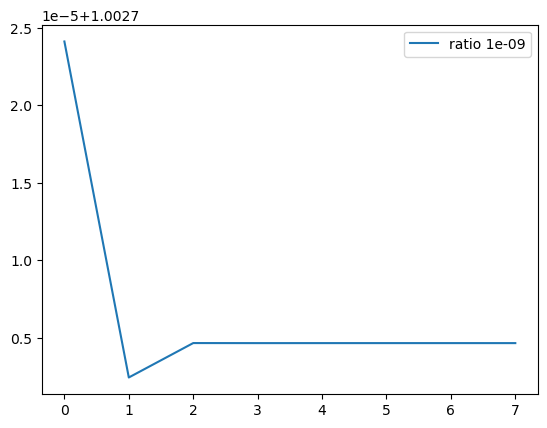

Noise level 	 order 	 	 ratio 	 	 threshold
1e-08
1.4132394705097585e-06
	  	 2 	 	 1.003e+00 	 1.087e+03
	  	 3 	 	 1.003e+00 	 3.371e+04
	  	 4 	 	 1.003e+00 	 3.726e+05
	  	 5 	 	 1.003e+00 	 5.359e+05
	  	 6 	 	 1.003e+00 	 5.431e+05
	  	 7 	 	 1.003e+00 	 5.433e+05
	  	 8 	 	 1.003e+00 	 5.433e+05
	  	 9 	 	 1.003e+00 	 5.433e+05


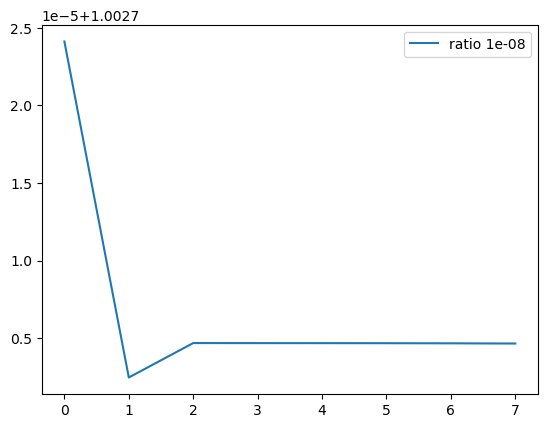

Noise level 	 order 	 	 ratio 	 	 threshold
1e-07
1.411537910292402e-05
	  	 2 	 	 1.003e+00 	 1.067e+03
	  	 3 	 	 1.003e+00 	 2.149e+04
	  	 4 	 	 1.003e+00 	 5.113e+04
	  	 5 	 	 1.003e+00 	 5.336e+04
	  	 6 	 	 1.003e+00 	 5.343e+04
	  	 7 	 	 1.003e+00 	 5.343e+04
	  	 8 	 	 1.003e+00 	 5.343e+04
	  	 9 	 	 1.003e+00 	 5.343e+04


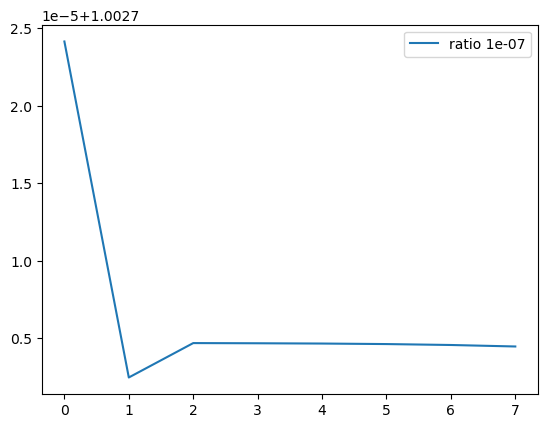

Noise level 	 order 	 	 ratio 	 	 threshold
1e-06
0.00014216067558414205
	  	 2 	 	 1.003e+00 	 8.946e+02
	  	 3 	 	 1.003e+00 	 4.397e+03
	  	 4 	 	 1.003e+00 	 4.989e+03
	  	 5 	 	 1.003e+00 	 5.009e+03
	  	 6 	 	 1.003e+00 	 5.010e+03
	  	 7 	 	 1.003e+00 	 5.010e+03
	  	 8 	 	 1.003e+00 	 5.010e+03
	  	 9 	 	 1.003e+00 	 5.010e+03


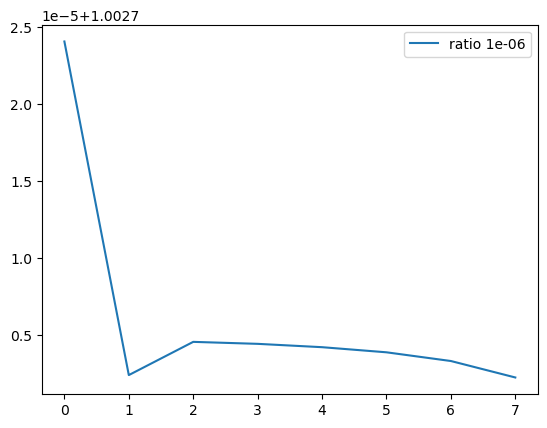

Noise level 	 order 	 	 ratio 	 	 threshold
1e-05
0.0013952636718154087
	  	 2 	 	 1.003e+00 	 3.690e+02
	  	 3 	 	 1.003e+00 	 5.495e+02
	  	 4 	 	 1.003e+00 	 5.578e+02
	  	 5 	 	 1.003e+00 	 5.580e+02
	  	 6 	 	 1.003e+00 	 5.580e+02
	  	 7 	 	 1.003e+00 	 5.580e+02
	  	 8 	 	 1.003e+00 	 5.580e+02
	  	 9 	 	 1.003e+00 	 5.580e+02


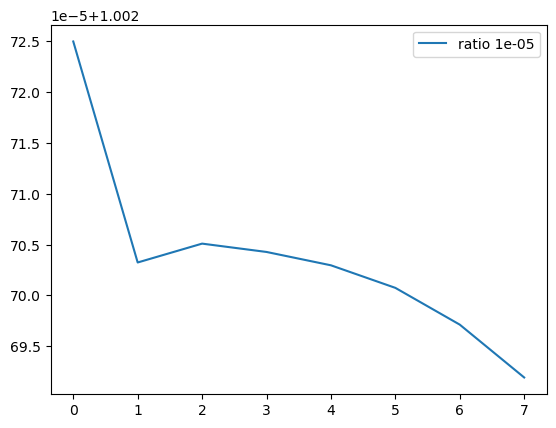

Noise level 	 order 	 	 ratio 	 	 threshold
0.0001
0.01409415051244508
	  	 2 	 	 1.003e+00 	 4.993e+01
	  	 3 	 	 1.003e+00 	 5.225e+01
	  	 4 	 	 1.003e+00 	 5.232e+01
	  	 5 	 	 1.003e+00 	 5.233e+01
	  	 6 	 	 1.003e+00 	 5.233e+01
	  	 7 	 	 1.003e+00 	 5.233e+01
	  	 8 	 	 1.003e+00 	 5.233e+01
	  	 9 	 	 1.003e+00 	 5.233e+01


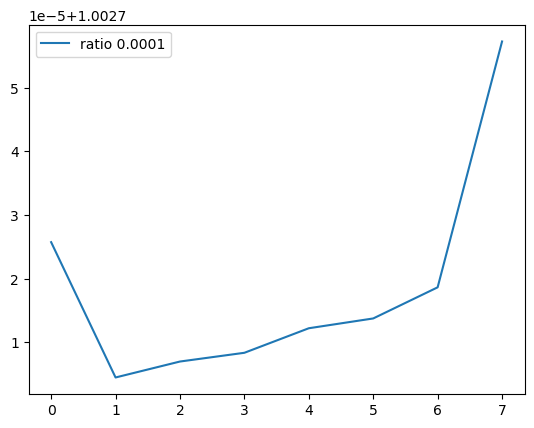

Noise level 	 order 	 	 ratio 	 	 threshold
0.001
0.14021291140349681
	  	 2 	 	 1.003e+00 	 5.345e+00
	  	 3 	 	 1.003e+00 	 5.371e+00
	  	 4 	 	 1.003e+00 	 5.371e+00
	  	 5 	 	 1.003e+00 	 5.371e+00
	  	 6 	 	 1.003e+00 	 5.371e+00
	  	 7 	 	 1.005e+00 	 5.371e+00
	  	 8 	 	 1.011e+00 	 5.371e+00
	  	 9 	 	 1.032e+00 	 5.371e+00


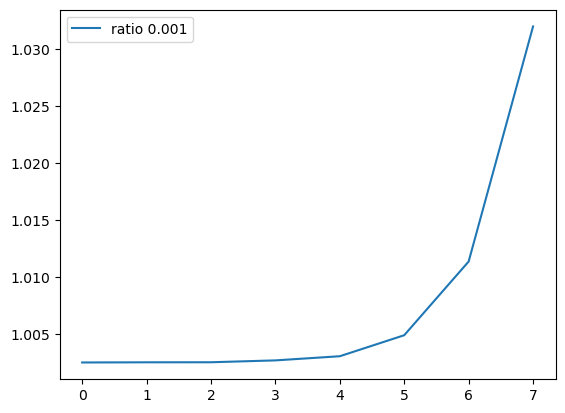

Noise level 	 order 	 	 ratio 	 	 threshold
0.01
1.400380891149021
	  	 2 	 	 1.033e+00 	 4.723e-01
	  	 3 	 	 1.084e+00 	 4.725e-01
	  	 4 	 	 1.077e+00 	 4.726e-01
	  	 5 	 	 1.134e+00 	 4.726e-01
	  	 6 	 	 1.203e+00 	 4.726e-01
	  	 7 	 	 1.411e+00 	 4.726e-01
	  	 8 	 	 1.853e+00 	 4.726e-01
	  	 9 	 	 2.785e+00 	 4.726e-01


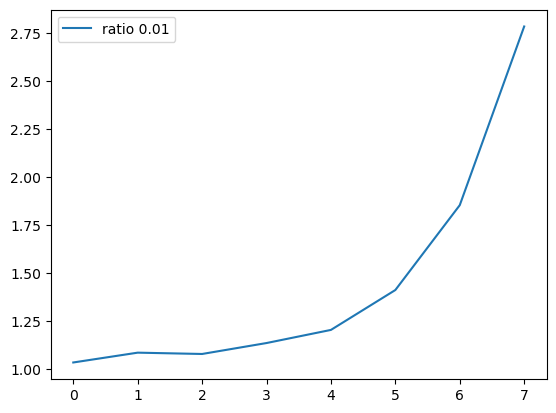

In [14]:
M=infinity_norm(uxxx)
number_noise=10 #<=10
noise_levels = [0]+[10**(-10+i) for i in range(0,number_noise-1)]
orders=range(2,10,1)
print(f"True ratio: {sv_max/sv_min:3.3e}")
unorm2=np.sqrt(np.mean(np.square(u)))

for target_noise in noise_levels:
    print("Noise level \t order \t \t ratio \t \t threshold")
    print(f"{target_noise}")
    
    threshold_list = []
    ratio_list=[]
    
    var = target_noise * unorm2
    noise = np.random.normal(0, var, size=u.shape)
    print(np.linalg.norm(noise))
    u_noise = u + noise
    eps_two = np.linalg.norm(u-u_noise)
    eps_infty = infinity_norm(u-u_noise)
    
    for order in orders:        
        threshold = calc_threshold(eps_infty,dx,true_g.shape[0],order)
        ux_noise = ps.FiniteDifference(order=order,d=1, axis=0, drop_endpoints=False)._differentiate(u_noise, dx)
        u_flat_noise, u_x_flat_noise = u_noise.flatten(), ux_noise.flatten()
        g_noise = np.concatenate([u_flat_noise.reshape(len(u_flat_noise),1), u_x_flat_noise.reshape(len(u_flat_noise),1)], axis=1)
        sv = svd(g_noise, compute_uv=False)
        ratio=sv[0]/sv[-1]
        
        threshold_list.append(threshold)
        ratio_list.append(ratio)

        
        print(f"\t  \t {order} \t \t {ratio:3.3e} \t {threshold:3.3e}")
    
    plt.plot(ratio_list,label=f'ratio {target_noise}')
    #plt.plot(threshold_list,'--',label=f'threshold {target_noise}')
    #plt.yscale('log')
    plt.legend()
    plt.show()